## Notebook for training for STATIONARY stock price with rolling forecast
Forecast for last 10% of data. Data is stationary (differenced), forecast is done day by day.
- Sequential model
- LSTM model
- STATIONARY
- rolling forecast

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.stats as si
from IPython.display import Image
import datetime
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing, metrics
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


In [2]:
backup = pd.HDFStore('backup_v07.h5')
#df = backup['df']
#df_sta = backup['df_sta']
#unscaled_seq_predictions = backup['unscaled_seq_predictions']
#unscaled_data = backup['unscaled_data']
#unscaled_lstm_predictions = backup['unscaled_lstm_predictions']
#test_data_unscaled = backup['test_data_unscaled']
#df_predicted = backup['df_predicted']

### Iron Condor
The iron condor is a investment strategy using four option with the same strike date. More precise, the iron condor uses two vertical spreads, one put spread and a call spread. The put spread consists at of a short put option (P_s) with a strike price below the actual stock price and a long put option (P_l) with a strike price below the short put option P_s. The call spread consists of a short call option (C_s) above the actual stock price and a long call option (C_l) above the short call option C_s. All options have the same strike date and the spread on both legs can vary but is chosen mostly the same.
![title](Condor_strategy.png)
"A trader who buys an iron condor speculates that the spot price of the underlying instrument will be between the short strikes when the options expire where the position is the most profitable. Thus, the iron condor is an options strategy considered when the trader has a neutral outlook for the market. Buying iron condors are popular with traders who seek regular income from their trading capital. An iron condor buyer will attempt to construct the trade so that the short strikes are close enough that the position will earn a desirable net credit, but wide enough apart so that it is likely that the spot price of the underlying will remain between the short strikes for the duration of the options contract. The trader would typically play iron condors every month (if possible) thus generating monthly income with the strategy." [https://en.wikipedia.org/wiki/Iron_condor]

### Goal of the project
The goal of the project is to find a strategy to maximise the profit with an iron condor. The ideal short and long spreads should be found at any time based on data of the underlying stock and of the indices S&P500 and Nasdaq

In [3]:
def get_data(var_name,name):
    # reads in csv into DataFrame, keeps Adj Close and Volume and calculates rolling averages and 
    # rolling standard deviation of Adj Close for 4, 9 and 18 days
    # var_name: path to csv file
    # name: name of the column df
    df = pd.read_csv('data/'+var_name+'.csv',index_col='Date', parse_dates=True)
    df.rename(columns={"Adj Close": name, "Volume": name+'_volume', "Open": name+'_open'}, inplace = True)
    df.rename(columns={"High": name+'_high', "Low": name+'_low', "Close": name+'_close'}, inplace = True)
    #df.drop(['Open','High','Low','Close'],axis=1, inplace = True)
    #if name == 'google':
        #df['google_45d'] = df['google'].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df[name+'_ra_04'] = df[name].rolling('4d').mean()
    df[name+'_std_04'] = df[name].rolling('4d').std()
    df[name+'_ra_09'] = df[name].rolling('9d').mean()
    df[name+'_std_09'] = df[name].rolling('9d').std()
    df[name+'_ra_18'] = df[name].rolling('18d').mean()
    df[name+'_std_18'] = df[name].rolling('18d').std()
    return df

In [4]:
def sigma_fct(df, name, days = 10):
    # For Black-Scholes I need the volatility of return of the underlying assets in the last days
    # based on https://www.wikihow.com/Calculate-Historical-Stock-Volatility
    # First the ln of daily returns is calculated for each element of names
    for name in names:
        a=pd.DataFrame()
        a['ln_daily_return'] = np.log(df[name] / df[name].shift(1))
        # next the rolling average (mean) over certain days is calculated
        a['rol_avg'] =  a['ln_daily_return'].rolling(str(days)+'d').mean()
        # next deviation from the mean is calculated
        a['dev_mean'] = a['ln_daily_return'] - a['rol_avg']
        # next variance is calculated for certain days
        a['dev_mean_sq'] = a['dev_mean']**2
        a['variance'] = a['dev_mean_sq'].rolling(str(days)+'d').sum()/(a['dev_mean_sq'].rolling(str(days)+'d').count()-1)
        # volatility is square root of variance
        # do you need annual volatility?
        df[name + '_daily_vol'] = np.sqrt(a['variance'])*np.sqrt(252) # 252 trading days in a year
        #df.drop(['ln_daily_return'])#,'rol_avg','dev_mean','dev_mean_sq','variance'])
        #return df[name + '_daily_vol']
    return df

In [5]:
def stationary_timeseries(df, damned_list = ['volume','std','short','daily']):
    # makes columns in df that are not in damned list stationary. Means it calculates the 
    # difference row by row
    columns = df.columns
    df_sta = pd.DataFrame()
    for column in columns:
        if any(elem in column for elem in damned_list):
            df_sta[column] = df[column]
        else:
            df_sta[column+'_sta'] = df[column].shift(1) - df[column]
    df_sta.dropna(inplace = True)  # to make sure we have all the data on all the days
    return df_sta

In [6]:
def get_df(var_name_list,name_list):
    # takes list paths of csv files and names and passes it on to get_data.
    # Gets df from get_data and merges them on 'Date'
    # Calls sigma_fct to get sigma of daily returns 
    # var_name_list: list of paths to csv files
    # name: list of names the columns of df
    i=0
    for var_name in var_name_list:
        if i == 0:
            df = get_data(var_name, name_list[i])
        else:
            df = pd.merge(df,get_data(var_name, name_list[i]),on='Date')
        i += 1
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    
    df = sigma_fct(df,names)
    df=df[23:] # drop first entries to get clean results

    return df

In [7]:
def get_target_data(df, name):
    # function to create the target data
    # name: name of the column the target data is created of
    df[name+'_45d'] = df[name].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    # df['short_call'] shows the perfect short call. If you would have shorted a call option with a strike price 
    # exactly the same as the stock price 45 days later, you made maximum profit. Therefore this is the target 
    # value for the short call option. The minimum is 0, so we never short a call option with a strike price
    # below the stock price right now. The same for the short put option
    #df['short_call'] = [x/y-1 if x/y > 1 else 0 for x,y in df[[name+'_45d', name]].values]
    #df['short_put'] = [1-x/y if x/y < 1 else 0 for x,y in df[[name+'_45d', name]].values]
    return df

In [8]:
var_names = ['GOOG','S&P','Nasdaq2']
names = ['google','s&p','nasdaq']
df = get_df(var_names, names)
df = get_target_data(df, 'google')
df.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-21,130.764862,134.182053,123.188263,130.725006,130.725006,20565700,136.935478,8.750923,143.875715,10.798013,...,1392.540009,68.742234,1452.251430,95.188063,1541.462141,127.530682,0.716470,0.802275,0.738519,156.946732
2008-11-24,134.127258,134.470963,124.040070,128.239334,128.239334,20184700,129.482170,1.757636,137.580147,9.599201,...,1428.184998,61.992083,1420.705017,68.914436,1498.502503,101.345711,0.529842,0.864400,0.777819,155.761169
2008-11-25,133.838348,142.794769,133.160873,140.498383,140.498383,21623100,134.368858,8.668457,137.997038,8.831976,...,1468.375000,5.154837,1426.994298,65.073432,1483.279999,90.035297,0.833833,0.791313,0.710049,156.573120
2008-11-26,139.616684,147.178345,137.584305,145.499634,145.499634,12760800,138.079117,8.880829,137.425609,8.059325,...,1489.616659,36.971751,1434.144287,74.235572,1487.035382,87.259170,0.812863,0.758392,0.707779,149.923050
2008-11-28,144.747452,147.671494,143.601746,145.933014,145.933014,5150200,143.977010,3.020363,136.698456,8.236770,...,1510.799967,39.935485,1450.814982,86.016593,1480.791532,79.789023,0.871477,0.804582,0.756923,148.936752


### Stationary timeseries
It is clearly visible, that the stock price has a upward trend. But in order to make predictions easier we try to make the time series data stationary. A stationary timeseries is a timeseries with constant mean, variance and covariance. Here we only make the mean constant. We do this by a lag=1 differencing, or said in different words
- we look at the daily change
- we look at the offset of the timeseries

But first we have to check which feature (column) shows a trend. I do not use statistical test like the Augmented Dickey Fuller Test or the Kwiatkowski-Phillips-Schmidt-Shin Test, but simply to it by visual inspection.

If the stock price shows an upward trend, so does S&P 500 and Nasdaq and all of their averages. Not a trend of the mean show all standard deviations, volumens and daily volatility of annual return.

In [9]:
df_sta = stationary_timeseries(df)
df_sta['google_45d'] = df.google_45d # add it to be able to reverse differencing
df_sta.head()

,google_open_sta,google_high_sta,google_low_sta,google_close_sta,google_sta,google_volume,google_ra_04_sta,google_std_04,google_ra_09_sta,google_std_09,...,nasdaq_std_04,nasdaq_ra_09_sta,nasdaq_std_09,nasdaq_ra_18_sta,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d_sta,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-24,-3.362396,-0.288910,-0.851807,2.485672,2.485672,20184700,7.453308,1.757636,6.295568,9.599201,...,61.992083,31.546413,68.914436,42.959638,101.345711,0.529842,0.864400,0.777819,1.185563,155.761169
2008-11-25,0.288910,-8.323806,-9.120803,-12.259049,-12.259049,21623100,-4.886688,8.668457,-0.416891,8.831976,...,5.154837,-6.289280,65.073432,15.222504,90.035297,0.833833,0.791313,0.710049,-0.811951,156.573120
2008-11-26,-5.778336,-4.383576,-4.423432,-5.001251,-5.001251,12760800,-3.710259,8.880829,0.571429,8.059325,...,36.971751,-7.149990,74.235572,-3.755383,87.259170,0.812863,0.758392,0.707779,6.650070,149.923050
2008-11-28,-5.130768,-0.493149,-6.017441,-0.433380,-0.433380,5150200,-5.897893,3.020363,0.727153,8.236770,...,39.935485,-16.670695,86.016593,6.243850,79.789023,0.871477,0.804582,0.756923,0.986298,148.936752
2008-12-01,1.942719,4.518067,11.108368,13.434647,13.434647,11465100,4.761320,9.499730,-1.835291,7.898311,...,97.227182,-29.682991,56.591903,28.832448,70.921223,1.198604,0.976937,0.988249,-0.338730,149.275482


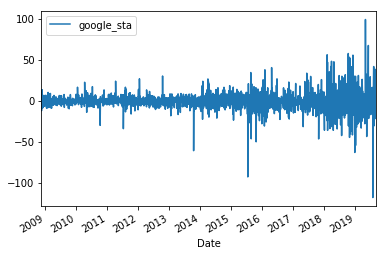

In [10]:
df_sta.reset_index().plot( x='Date', y=['google_sta'])

In [11]:
backup['df'] = df
backup['df_sta'] = df_sta

### Price of options
It is really hard to get data about historic stock options. Be it as api channel or csv download. I managed only to find sources to pay: 500 USD for every year. Because that is too expensive for this project I decided to calculate the option price with the **Black–Scholes formula**, which gives a theoretical estimate of the price of European-style options.

Based on the formula for non-divident paying options I calculate the option prices and add a small random term to create a bit of noise.

In [12]:
def black_scholes(S, K, sigma, r=0.03, T=45/365, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity in years, 45 days as default
    #r: risk-free interest rate, assumed to be constant between t and T
    #sigma: standard deviation (volatility) of RETURNS of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    #d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [13]:
def option_prices(date, short_spread, long_spread, strike_days = 45):
    # calculates prices of options and calculates initial return (net premium)
    date = date_fct(date)
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(date, short_spread, long_spread)
    sigma = get_sigma(date)
    stock_price = stock_price_fct(date)
    P_s_price = black_scholes(stock_price, P_s_strike_price, sigma, T=strike_days/365, option = 'put')
    P_l_price = black_scholes(stock_price, P_l_strike_price, sigma, T=strike_days/365, option = 'put')
    C_s_price = black_scholes(stock_price, C_s_strike_price, sigma, T=strike_days/365, option = 'call')
    C_l_price = black_scholes(stock_price, C_l_strike_price, sigma, T=strike_days/365, option = 'call')
    initial_return = P_s_price + C_s_price - P_l_price - C_l_price
    
    return P_s_price, P_l_price, C_s_price, C_l_price, initial_return

Now it is time to calculate the strike prices and option prices of all 4 options and the initial return by setting up the iron condor

### Calculate return of options
There are five different regimes for the return. R: return, P(C) put(call) option, s(l): short(long), ir: initial return, stock_price: stock price
- stock price is below long put option: R = ir + P_l_strike_price - P_s_strike_price
- stock price is between long and short put option: R = ir + stock_price - P_s_strike_price
- stock price is between short call and short put option: R = ir
- stock price is between short and long call option: R = ir - stock_price + C_s_strike price
- stock price is above long call option: R = ir - C_l_strike_price + C_s_strike_price

#### Define return function of iron condor

In [14]:
def ic_return(trading_date, short_spread, long_spread, strike_days = 45):
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(trading_date, short_spread, long_spread)
    P_s_price, P_l_price, C_s_price, C_l_price, initial_return = option_prices(trading_date,short_spread, long_spread, strike_days)
    strike_date = date_fct(trading_date, 45)
    final_stock_price = stock_price_fct(strike_date)
    if final_stock_price < P_l_strike_price:
        final_result = initial_return + P_l_strike_price - P_s_strike_price
    elif final_stock_price >= P_l_strike_price and final_stock_price < P_s_strike_price:
        final_result = initial_return + stock_price - P_s_strike_price
    elif final_stock_price >= P_s_strike_price and final_stock_price < C_s_strike_price:
        final_result = initial_return
    elif final_stock_price >= C_s_strike_price and final_stock_price < C_l_strike_price:
        final_result = initial_return - final_stock_price + C_s_strike_price
    elif final_stock_price >= C_l_strike_price:
        final_result = initial_return - C_l_strike_price + C_s_strike_price
    maximum_result = initial_return
    return final_result

### Building the model

#### Scale data

In [15]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
df_sta_scaled = pd.DataFrame(scaler.fit_transform(df_sta), columns=df_sta.columns, index = df_sta.index)

/home/matthias/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Split into train and test set

In [16]:
def get_train_test_data(data, train_test_split, batch_size):
    # data is dataframe to get train test data out of
    train_size_raw = data.shape[0]*train_test_split
    train_size = int(train_size_raw - train_size_raw % batch_size) # make train_size multiple of batch_size for "statefull = True" in LSTM
    train_data = data.iloc[0:train_size]
    test_size_raw = data.shape[0] - train_size
    test_size = int(test_size_raw - test_size_raw%batch_size) # multiple of batch_size
    test_data = data.iloc[train_size : train_size + test_size]
    x_train = train_data.drop(columns=['google_45d','google_45d_sta']) # google_45d is not for training, just for reversing stationarity
    y_train = train_data['google_45d_sta']
    x_test = test_data.drop(columns=['google_45d','google_45d_sta'])
    y_test = test_data['google_45d_sta']
    train_index=x_train.index
    x_columns = x_train.columns
    test_index = x_test.index
    return x_train, x_test, y_train, y_test, test_data, test_index, x_columns

In [17]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_sta_scaled, train_test_split, batch_size)

### Sequential model

In [18]:
# Build the model architecture
seq_model = Sequential()
seq_model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(16, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(4, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(1))

# Compile the model using a loss function and an optimizer.
seq_model.compile(optimizer='adam',loss='mean_squared_error')
seq_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
______________________

In [19]:
start = time.time()
history=seq_model.fit(x_train, y_train, epochs=3000, batch_size=50, verbose=1, validation_data=(x_test, y_test));
end = time.time()
time_seq = end-start


Train on 2370 samples, validate on 260 samples
Epoch 1/3000
2370/2370 [==============================] - 1s 486us/step - loss: 0.0108 - val_loss: 0.0375
Epoch 2/3000
2370/2370 [==============================] - 0s 133us/step - loss: 0.0070 - val_loss: 0.0359
Epoch 3/3000
2370/2370 [==============================] - 0s 137us/step - loss: 0.0063 - val_loss: 0.0356
Epoch 4/3000
2370/2370 [==============================] - 0s 131us/step - loss: 0.0062 - val_loss: 0.0357
Epoch 5/3000
2370/2370 [==============================] - 0s 135us/step - loss: 0.0062 - val_loss: 0.0356
Epoch 6/3000
2370/2370 [==============================] - 0s 128us/step - loss: 0.0062 - val_loss: 0.0357
Epoch 7/3000
2370/2370 [==============================] - 0s 114us/step - loss: 0.0061 - val_loss: 0.0357
Epoch 8/3000
2370/2370 [==============================] - 0s 112us/step - loss: 0.0061 - val_loss: 0.0358
Epoch 9/3000
2370/2370 [==============================] - 0s 100us/step - loss: 0.0061 - val_loss: 0.035

2370/2370 [==============================] - 0s 145us/step - loss: 0.0060 - val_loss: 0.0359
Epoch 76/3000
2370/2370 [==============================] - 0s 148us/step - loss: 0.0060 - val_loss: 0.0357
Epoch 77/3000
2370/2370 [==============================] - 0s 143us/step - loss: 0.0060 - val_loss: 0.0357
Epoch 78/3000
2370/2370 [==============================] - 0s 156us/step - loss: 0.0060 - val_loss: 0.0357
Epoch 79/3000
2370/2370 [==============================] - 0s 135us/step - loss: 0.0060 - val_loss: 0.0357
Epoch 80/3000
2370/2370 [==============================] - 0s 70us/step - loss: 0.0061 - val_loss: 0.0357
Epoch 81/3000
2370/2370 [==============================] - 0s 62us/step - loss: 0.0060 - val_loss: 0.0358
Epoch 82/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0061 - val_loss: 0.0360
Epoch 83/3000
2370/2370 [==============================] - 0s 110us/step - loss: 0.0061 - val_loss: 0.0357
Epoch 84/3000
2370/2370 [=============================

2370/2370 [==============================] - 0s 95us/step - loss: 0.0060 - val_loss: 0.0360
Epoch 152/3000
2370/2370 [==============================] - 0s 127us/step - loss: 0.0059 - val_loss: 0.0363
Epoch 153/3000
2370/2370 [==============================] - 0s 126us/step - loss: 0.0059 - val_loss: 0.0364
Epoch 154/3000
2370/2370 [==============================] - 0s 143us/step - loss: 0.0059 - val_loss: 0.0364
Epoch 155/3000
2370/2370 [==============================] - 0s 82us/step - loss: 0.0059 - val_loss: 0.0365
Epoch 156/3000
2370/2370 [==============================] - 0s 115us/step - loss: 0.0058 - val_loss: 0.0364
Epoch 157/3000
2370/2370 [==============================] - 0s 142us/step - loss: 0.0059 - val_loss: 0.0363
Epoch 158/3000
2370/2370 [==============================] - 0s 143us/step - loss: 0.0058 - val_loss: 0.0361
Epoch 159/3000
2370/2370 [==============================] - 0s 149us/step - loss: 0.0058 - val_loss: 0.0365
Epoch 160/3000
2370/2370 [===================

2370/2370 [==============================] - 0s 70us/step - loss: 0.0057 - val_loss: 0.0367
Epoch 228/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0057 - val_loss: 0.0371
Epoch 229/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0057 - val_loss: 0.0371
Epoch 230/3000
2370/2370 [==============================] - 0s 76us/step - loss: 0.0057 - val_loss: 0.0367
Epoch 231/3000
2370/2370 [==============================] - 0s 84us/step - loss: 0.0057 - val_loss: 0.0371
Epoch 232/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0058 - val_loss: 0.0371
Epoch 233/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0057 - val_loss: 0.0365
Epoch 234/3000
2370/2370 [==============================] - 0s 94us/step - loss: 0.0057 - val_loss: 0.0369
Epoch 235/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.0057 - val_loss: 0.0369
Epoch 236/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 71us/step - loss: 0.0055 - val_loss: 0.0363
Epoch 304/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0056 - val_loss: 0.0366
Epoch 305/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0056 - val_loss: 0.0361
Epoch 306/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0056 - val_loss: 0.0374
Epoch 307/3000
2370/2370 [==============================] - 0s 82us/step - loss: 0.0055 - val_loss: 0.0369
Epoch 308/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0057 - val_loss: 0.0370
Epoch 309/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0055 - val_loss: 0.0366
Epoch 310/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0056 - val_loss: 0.0368
Epoch 311/3000
2370/2370 [==============================] - 0s 72us/step - loss: 0.0057 - val_loss: 0.0367
Epoch 312/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 76us/step - loss: 0.0055 - val_loss: 0.0374
Epoch 380/3000
2370/2370 [==============================] - 0s 82us/step - loss: 0.0056 - val_loss: 0.0369
Epoch 381/3000
2370/2370 [==============================] - 0s 89us/step - loss: 0.0055 - val_loss: 0.0377
Epoch 382/3000
2370/2370 [==============================] - 0s 90us/step - loss: 0.0055 - val_loss: 0.0371
Epoch 383/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0055 - val_loss: 0.0371
Epoch 384/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.0055 - val_loss: 0.0377
Epoch 385/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0055 - val_loss: 0.0379
Epoch 386/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.0055 - val_loss: 0.0372
Epoch 387/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0055 - val_loss: 0.0380
Epoch 388/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 79us/step - loss: 0.0053 - val_loss: 0.0377
Epoch 456/3000
2370/2370 [==============================] - 0s 84us/step - loss: 0.0053 - val_loss: 0.0375
Epoch 457/3000
2370/2370 [==============================] - 0s 86us/step - loss: 0.0052 - val_loss: 0.0370
Epoch 458/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0052 - val_loss: 0.0368
Epoch 459/3000
2370/2370 [==============================] - 0s 90us/step - loss: 0.0054 - val_loss: 0.0371
Epoch 460/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0052 - val_loss: 0.0373
Epoch 461/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0053 - val_loss: 0.0370
Epoch 462/3000
2370/2370 [==============================] - 0s 72us/step - loss: 0.0053 - val_loss: 0.0375
Epoch 463/3000
2370/2370 [==============================] - 0s 85us/step - loss: 0.0052 - val_loss: 0.0380
Epoch 464/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 78us/step - loss: 0.0054 - val_loss: 0.0382
Epoch 532/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0053 - val_loss: 0.0383
Epoch 533/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0054 - val_loss: 0.0373
Epoch 534/3000
2370/2370 [==============================] - 0s 76us/step - loss: 0.0052 - val_loss: 0.0375
Epoch 535/3000
2370/2370 [==============================] - 0s 76us/step - loss: 0.0052 - val_loss: 0.0378
Epoch 536/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0052 - val_loss: 0.0379
Epoch 537/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0054 - val_loss: 0.0372
Epoch 538/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0053 - val_loss: 0.0373
Epoch 539/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0054 - val_loss: 0.0374
Epoch 540/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 84us/step - loss: 0.0051 - val_loss: 0.0384
Epoch 608/3000
2370/2370 [==============================] - 0s 98us/step - loss: 0.0051 - val_loss: 0.0383
Epoch 609/3000
2370/2370 [==============================] - 0s 94us/step - loss: 0.0053 - val_loss: 0.0380
Epoch 610/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0052 - val_loss: 0.0379
Epoch 611/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0052 - val_loss: 0.0379
Epoch 612/3000
2370/2370 [==============================] - 0s 87us/step - loss: 0.0051 - val_loss: 0.0384
Epoch 613/3000
2370/2370 [==============================] - 0s 93us/step - loss: 0.0050 - val_loss: 0.0389
Epoch 614/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0052 - val_loss: 0.0386
Epoch 615/3000
2370/2370 [==============================] - 0s 90us/step - loss: 0.0055 - val_loss: 0.0379
Epoch 616/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 99us/step - loss: 0.0050 - val_loss: 0.0381
Epoch 684/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0052 - val_loss: 0.0372
Epoch 685/3000
2370/2370 [==============================] - 0s 76us/step - loss: 0.0050 - val_loss: 0.0374
Epoch 686/3000
2370/2370 [==============================] - 0s 74us/step - loss: 0.0052 - val_loss: 0.0373
Epoch 687/3000
2370/2370 [==============================] - 0s 92us/step - loss: 0.0052 - val_loss: 0.0372
Epoch 688/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0053 - val_loss: 0.0374
Epoch 689/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0051 - val_loss: 0.0381
Epoch 690/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0051 - val_loss: 0.0376
Epoch 691/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0051 - val_loss: 0.0379
Epoch 692/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 81us/step - loss: 0.0050 - val_loss: 0.0380
Epoch 760/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0050 - val_loss: 0.0375
Epoch 761/3000
2370/2370 [==============================] - 0s 60us/step - loss: 0.0049 - val_loss: 0.0381
Epoch 762/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0051 - val_loss: 0.0373
Epoch 763/3000
2370/2370 [==============================] - 0s 72us/step - loss: 0.0049 - val_loss: 0.0384
Epoch 764/3000
2370/2370 [==============================] - 0s 100us/step - loss: 0.0051 - val_loss: 0.0381
Epoch 765/3000
2370/2370 [==============================] - 0s 85us/step - loss: 0.0051 - val_loss: 0.0384
Epoch 766/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0050 - val_loss: 0.0381
Epoch 767/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0051 - val_loss: 0.0376
Epoch 768/3000
2370/2370 [=========================

2370/2370 [==============================] - 0s 98us/step - loss: 0.0049 - val_loss: 0.0383
Epoch 836/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0050 - val_loss: 0.0384
Epoch 837/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0049 - val_loss: 0.0378
Epoch 838/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.0048 - val_loss: 0.0385
Epoch 839/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0047 - val_loss: 0.0378
Epoch 840/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.0049 - val_loss: 0.0380
Epoch 841/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0048 - val_loss: 0.0383
Epoch 842/3000
2370/2370 [==============================] - 0s 87us/step - loss: 0.0049 - val_loss: 0.0393
Epoch 843/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0049 - val_loss: 0.0383
Epoch 844/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 79us/step - loss: 0.0049 - val_loss: 0.0384
Epoch 912/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0049 - val_loss: 0.0389
Epoch 913/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.0049 - val_loss: 0.0373
Epoch 914/3000
2370/2370 [==============================] - 0s 62us/step - loss: 0.0052 - val_loss: 0.0384
Epoch 915/3000
2370/2370 [==============================] - 0s 82us/step - loss: 0.0049 - val_loss: 0.0377
Epoch 916/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0051 - val_loss: 0.0378
Epoch 917/3000
2370/2370 [==============================] - 0s 64us/step - loss: 0.0048 - val_loss: 0.0384
Epoch 918/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0050 - val_loss: 0.0383
Epoch 919/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0048 - val_loss: 0.0385
Epoch 920/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 87us/step - loss: 0.0048 - val_loss: 0.0391
Epoch 988/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0050 - val_loss: 0.0377
Epoch 989/3000
2370/2370 [==============================] - 0s 85us/step - loss: 0.0048 - val_loss: 0.0390
Epoch 990/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0046 - val_loss: 0.0388
Epoch 991/3000
2370/2370 [==============================] - 0s 82us/step - loss: 0.0048 - val_loss: 0.0383
Epoch 992/3000
2370/2370 [==============================] - 0s 89us/step - loss: 0.0050 - val_loss: 0.0384
Epoch 993/3000
2370/2370 [==============================] - 0s 88us/step - loss: 0.0049 - val_loss: 0.0379
Epoch 994/3000
2370/2370 [==============================] - 0s 89us/step - loss: 0.0048 - val_loss: 0.0383
Epoch 995/3000
2370/2370 [==============================] - 0s 102us/step - loss: 0.0047 - val_loss: 0.0375
Epoch 996/3000
2370/2370 [=========================

2370/2370 [==============================] - 0s 63us/step - loss: 0.0047 - val_loss: 0.0384
Epoch 1064/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.0047 - val_loss: 0.0379
Epoch 1065/3000
2370/2370 [==============================] - 0s 64us/step - loss: 0.0048 - val_loss: 0.0383
Epoch 1066/3000
2370/2370 [==============================] - 0s 72us/step - loss: 0.0046 - val_loss: 0.0386
Epoch 1067/3000
2370/2370 [==============================] - 0s 76us/step - loss: 0.0047 - val_loss: 0.0385
Epoch 1068/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0047 - val_loss: 0.0379
Epoch 1069/3000
2370/2370 [==============================] - 0s 65us/step - loss: 0.0048 - val_loss: 0.0379
Epoch 1070/3000
2370/2370 [==============================] - 0s 69us/step - loss: 0.0048 - val_loss: 0.0385
Epoch 1071/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0047 - val_loss: 0.0382
Epoch 1072/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 65us/step - loss: 0.0048 - val_loss: 0.0388
Epoch 1140/3000
2370/2370 [==============================] - 0s 62us/step - loss: 0.0044 - val_loss: 0.0382
Epoch 1141/3000
2370/2370 [==============================] - 0s 72us/step - loss: 0.0045 - val_loss: 0.0393
Epoch 1142/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0045 - val_loss: 0.0394
Epoch 1143/3000
2370/2370 [==============================] - 0s 82us/step - loss: 0.0046 - val_loss: 0.0387
Epoch 1144/3000
2370/2370 [==============================] - 0s 98us/step - loss: 0.0046 - val_loss: 0.0381
Epoch 1145/3000
2370/2370 [==============================] - 0s 92us/step - loss: 0.0047 - val_loss: 0.0385
Epoch 1146/3000
2370/2370 [==============================] - 0s 85us/step - loss: 0.0047 - val_loss: 0.0385
Epoch 1147/3000
2370/2370 [==============================] - 0s 95us/step - loss: 0.0046 - val_loss: 0.0393
Epoch 1148/3000
2370/2370 [=================

Epoch 1215/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0047 - val_loss: 0.0389
Epoch 1216/3000
2370/2370 [==============================] - 0s 94us/step - loss: 0.0047 - val_loss: 0.0395
Epoch 1217/3000
2370/2370 [==============================] - 0s 87us/step - loss: 0.0047 - val_loss: 0.0385
Epoch 1218/3000
2370/2370 [==============================] - 0s 86us/step - loss: 0.0046 - val_loss: 0.0397
Epoch 1219/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0046 - val_loss: 0.0394
Epoch 1220/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0045 - val_loss: 0.0409
Epoch 1221/3000
2370/2370 [==============================] - 0s 64us/step - loss: 0.0045 - val_loss: 0.0389
Epoch 1222/3000
2370/2370 [==============================] - 0s 71us/step - loss: 0.0046 - val_loss: 0.0389
Epoch 1223/3000
2370/2370 [==============================] - 0s 74us/step - loss: 0.0044 - val_loss: 0.0391
Epoch 1224/3000
2370/2370 [=

Epoch 1291/3000
2370/2370 [==============================] - 0s 86us/step - loss: 0.0047 - val_loss: 0.0373
Epoch 1292/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0048 - val_loss: 0.0382
Epoch 1293/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0049 - val_loss: 0.0375
Epoch 1294/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0047 - val_loss: 0.0365
Epoch 1295/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.0047 - val_loss: 0.0370
Epoch 1296/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0043 - val_loss: 0.0374
Epoch 1297/3000
2370/2370 [==============================] - 0s 74us/step - loss: 0.0046 - val_loss: 0.0382
Epoch 1298/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0045 - val_loss: 0.0367
Epoch 1299/3000
2370/2370 [==============================] - 0s 70us/step - loss: 0.0046 - val_loss: 0.0371
Epoch 1300/3000
2370/2370 [=

Epoch 1367/3000
2370/2370 [==============================] - 0s 72us/step - loss: 0.0046 - val_loss: 0.0374
Epoch 1368/3000
2370/2370 [==============================] - 0s 59us/step - loss: 0.0045 - val_loss: 0.0389
Epoch 1369/3000
2370/2370 [==============================] - 0s 64us/step - loss: 0.0045 - val_loss: 0.0382
Epoch 1370/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0048 - val_loss: 0.0378
Epoch 1371/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.0044 - val_loss: 0.0376
Epoch 1372/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0045 - val_loss: 0.0385
Epoch 1373/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0046 - val_loss: 0.0381
Epoch 1374/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0044 - val_loss: 0.0380
Epoch 1375/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0044 - val_loss: 0.0386
Epoch 1376/3000
2370/2370 [=

Epoch 1443/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0045 - val_loss: 0.0376
Epoch 1444/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0043 - val_loss: 0.0383
Epoch 1445/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0042 - val_loss: 0.0385
Epoch 1446/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0044 - val_loss: 0.0386
Epoch 1447/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0045 - val_loss: 0.0398
Epoch 1448/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0043 - val_loss: 0.0393
Epoch 1449/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0046 - val_loss: 0.0388
Epoch 1450/3000
2370/2370 [==============================] - 0s 70us/step - loss: 0.0046 - val_loss: 0.0387
Epoch 1451/3000
2370/2370 [==============================] - 0s 99us/step - loss: 0.0042 - val_loss: 0.0393
Epoch 1452/3000
2370/2370 [=

Epoch 1519/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0043 - val_loss: 0.0390
Epoch 1520/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.0043 - val_loss: 0.0383
Epoch 1521/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0046 - val_loss: 0.0382
Epoch 1522/3000
2370/2370 [==============================] - 0s 102us/step - loss: 0.0044 - val_loss: 0.0383
Epoch 1523/3000
2370/2370 [==============================] - 0s 92us/step - loss: 0.0045 - val_loss: 0.0387
Epoch 1524/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0043 - val_loss: 0.0378
Epoch 1525/3000
2370/2370 [==============================] - 0s 79us/step - loss: 0.0044 - val_loss: 0.0387
Epoch 1526/3000
2370/2370 [==============================] - 0s 97us/step - loss: 0.0043 - val_loss: 0.0382
Epoch 1527/3000
2370/2370 [==============================] - 0s 93us/step - loss: 0.0043 - val_loss: 0.0382
Epoch 1528/3000
2370/2370 [

Epoch 1595/3000
2370/2370 [==============================] - 0s 61us/step - loss: 0.0043 - val_loss: 0.0383
Epoch 1596/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0044 - val_loss: 0.0377
Epoch 1597/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0045 - val_loss: 0.0387
Epoch 1598/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0045 - val_loss: 0.0378
Epoch 1599/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0044 - val_loss: 0.0382
Epoch 1600/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0042 - val_loss: 0.0369
Epoch 1601/3000
2370/2370 [==============================] - 0s 63us/step - loss: 0.0043 - val_loss: 0.0376
Epoch 1602/3000
2370/2370 [==============================] - 0s 64us/step - loss: 0.0044 - val_loss: 0.0387
Epoch 1603/3000
2370/2370 [==============================] - 0s 74us/step - loss: 0.0045 - val_loss: 0.0383
Epoch 1604/3000
2370/2370 [=

Epoch 1671/3000
2370/2370 [==============================] - 0s 77us/step - loss: 0.0044 - val_loss: 0.0377
Epoch 1672/3000
2370/2370 [==============================] - 0s 86us/step - loss: 0.0042 - val_loss: 0.0390
Epoch 1673/3000
2370/2370 [==============================] - 0s 37us/step - loss: 0.0046 - val_loss: 0.0380
Epoch 1674/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0044 - val_loss: 0.0381
Epoch 1675/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0046 - val_loss: 0.0374
Epoch 1676/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0044 - val_loss: 0.0385
Epoch 1677/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0046 - val_loss: 0.0385
Epoch 1678/3000
2370/2370 [==============================] - 0s 102us/step - loss: 0.0041 - val_loss: 0.0400
Epoch 1679/3000
2370/2370 [==============================] - 0s 88us/step - loss: 0.0044 - val_loss: 0.0376
Epoch 1680/3000
2370/2370 [

2370/2370 [==============================] - 0s 93us/step - loss: 0.0045 - val_loss: 0.0384
Epoch 1747/3000
2370/2370 [==============================] - 0s 99us/step - loss: 0.0043 - val_loss: 0.0385
Epoch 1748/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0044 - val_loss: 0.0382
Epoch 1749/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0042 - val_loss: 0.0386
Epoch 1750/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0044 - val_loss: 0.0386
Epoch 1751/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0043 - val_loss: 0.0385
Epoch 1752/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0045 - val_loss: 0.0379
Epoch 1753/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0045 - val_loss: 0.0378
Epoch 1754/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0045 - val_loss: 0.0387
Epoch 1755/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 41us/step - loss: 0.0045 - val_loss: 0.0370
Epoch 1823/3000
2370/2370 [==============================] - 0s 48us/step - loss: 0.0044 - val_loss: 0.0379
Epoch 1824/3000
2370/2370 [==============================] - 0s 43us/step - loss: 0.0043 - val_loss: 0.0370
Epoch 1825/3000
2370/2370 [==============================] - 0s 46us/step - loss: 0.0045 - val_loss: 0.0381
Epoch 1826/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0045 - val_loss: 0.0384
Epoch 1827/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0041 - val_loss: 0.0373
Epoch 1828/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0042 - val_loss: 0.0379
Epoch 1829/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0045 - val_loss: 0.0374
Epoch 1830/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0041 - val_loss: 0.0378
Epoch 1831/3000
2370/2370 [=================

Epoch 1898/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0044 - val_loss: 0.0376
Epoch 1899/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0043 - val_loss: 0.0377
Epoch 1900/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0042 - val_loss: 0.0388
Epoch 1901/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0043 - val_loss: 0.0377
Epoch 1902/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0042 - val_loss: 0.0382
Epoch 1903/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0042 - val_loss: 0.0382
Epoch 1904/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0044 - val_loss: 0.0381
Epoch 1905/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0041 - val_loss: 0.0395
Epoch 1906/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0387
Epoch 1907/3000
2370/2370 [=

Epoch 1974/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0042 - val_loss: 0.0377
Epoch 1975/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0042 - val_loss: 0.0374
Epoch 1976/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0042 - val_loss: 0.0380
Epoch 1977/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0039 - val_loss: 0.0392
Epoch 1978/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0040 - val_loss: 0.0385
Epoch 1979/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0040 - val_loss: 0.0378
Epoch 1980/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0378
Epoch 1981/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0040 - val_loss: 0.0380
Epoch 1982/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0039 - val_loss: 0.0386
Epoch 1983/3000
2370/2370 [=

Epoch 2050/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0041 - val_loss: 0.0385
Epoch 2051/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0042 - val_loss: 0.0376
Epoch 2052/3000
2370/2370 [==============================] - 0s 38us/step - loss: 0.0042 - val_loss: 0.0378
Epoch 2053/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0043 - val_loss: 0.0382
Epoch 2054/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0043 - val_loss: 0.0389
Epoch 2055/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0045 - val_loss: 0.0380
Epoch 2056/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0042 - val_loss: 0.0383
Epoch 2057/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0043 - val_loss: 0.0383
Epoch 2058/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0042 - val_loss: 0.0382
Epoch 2059/3000
2370/2370 [=

Epoch 2126/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0041 - val_loss: 0.0374
Epoch 2127/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0042 - val_loss: 0.0379
Epoch 2128/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0042 - val_loss: 0.0386
Epoch 2129/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0041 - val_loss: 0.0376
Epoch 2130/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0042 - val_loss: 0.0379
Epoch 2131/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0041 - val_loss: 0.0385
Epoch 2132/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0041 - val_loss: 0.0383
Epoch 2133/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0042 - val_loss: 0.0382
Epoch 2134/3000
2370/2370 [==============================] - 0s 41us/step - loss: 0.0042 - val_loss: 0.0379
Epoch 2135/3000
2370/2370 [=

Epoch 2202/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0042 - val_loss: 0.0387
Epoch 2203/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0394
Epoch 2204/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0043 - val_loss: 0.0379
Epoch 2205/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0379
Epoch 2206/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0041 - val_loss: 0.0375
Epoch 2207/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0374
Epoch 2208/3000
2370/2370 [==============================] - 0s 62us/step - loss: 0.0040 - val_loss: 0.0379
Epoch 2209/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0040 - val_loss: 0.0380
Epoch 2210/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0040 - val_loss: 0.0386
Epoch 2211/3000
2370/2370 [=

Epoch 2278/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0039 - val_loss: 0.0376
Epoch 2279/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0041 - val_loss: 0.0369
Epoch 2280/3000
2370/2370 [==============================] - 0s 38us/step - loss: 0.0040 - val_loss: 0.0380
Epoch 2281/3000
2370/2370 [==============================] - 0s 73us/step - loss: 0.0043 - val_loss: 0.0385
Epoch 2282/3000
2370/2370 [==============================] - 0s 64us/step - loss: 0.0042 - val_loss: 0.0391
Epoch 2283/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0041 - val_loss: 0.0384
Epoch 2284/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0040 - val_loss: 0.0382
Epoch 2285/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0041 - val_loss: 0.0379
Epoch 2286/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0040 - val_loss: 0.0380
Epoch 2287/3000
2370/2370 [=

Epoch 2354/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0041 - val_loss: 0.0381
Epoch 2355/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0040 - val_loss: 0.0381
Epoch 2356/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0377
Epoch 2357/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0041 - val_loss: 0.0378
Epoch 2358/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0041 - val_loss: 0.0374
Epoch 2359/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0042 - val_loss: 0.0374
Epoch 2360/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0042 - val_loss: 0.0372
Epoch 2361/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0387
Epoch 2362/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0039 - val_loss: 0.0380
Epoch 2363/3000
2370/2370 [=

Epoch 2430/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0041 - val_loss: 0.0374
Epoch 2431/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0387
Epoch 2432/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0041 - val_loss: 0.0380
Epoch 2433/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0040 - val_loss: 0.0375
Epoch 2434/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0040 - val_loss: 0.0377
Epoch 2435/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0040 - val_loss: 0.0370
Epoch 2436/3000
2370/2370 [==============================] - 0s 44us/step - loss: 0.0038 - val_loss: 0.0378
Epoch 2437/3000
2370/2370 [==============================] - 0s 54us/step - loss: 0.0039 - val_loss: 0.0378
Epoch 2438/3000
2370/2370 [==============================] - 0s 54us/step - loss: 0.0042 - val_loss: 0.0381
Epoch 2439/3000
2370/2370 [=

Epoch 2506/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0376
Epoch 2507/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0042 - val_loss: 0.0373
Epoch 2508/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0040 - val_loss: 0.0377
Epoch 2509/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0040 - val_loss: 0.0385
Epoch 2510/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0373
Epoch 2511/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0039 - val_loss: 0.0378
Epoch 2512/3000
2370/2370 [==============================] - 0s 108us/step - loss: 0.0042 - val_loss: 0.0373
Epoch 2513/3000
2370/2370 [==============================] - 0s 83us/step - loss: 0.0041 - val_loss: 0.0370
Epoch 2514/3000
2370/2370 [==============================] - 0s 51us/step - loss: 0.0039 - val_loss: 0.0370
Epoch 2515/3000
2370/2370 [

2370/2370 [==============================] - 0s 27us/step - loss: 0.0039 - val_loss: 0.0385
Epoch 2582/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0039 - val_loss: 0.0383
Epoch 2583/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0383
Epoch 2584/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0038 - val_loss: 0.0386
Epoch 2585/3000
2370/2370 [==============================] - 0s 49us/step - loss: 0.0038 - val_loss: 0.0382
Epoch 2586/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0038 - val_loss: 0.0385
Epoch 2587/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0039 - val_loss: 0.0384
Epoch 2588/3000
2370/2370 [==============================] - 0s 43us/step - loss: 0.0038 - val_loss: 0.0381
Epoch 2589/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0043 - val_loss: 0.0380
Epoch 2590/3000
2370/2370 [=================

Epoch 2657/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0040 - val_loss: 0.0376
Epoch 2658/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0039 - val_loss: 0.0374
Epoch 2659/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0039 - val_loss: 0.0379
Epoch 2660/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0038 - val_loss: 0.0380
Epoch 2661/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0041 - val_loss: 0.0372
Epoch 2662/3000
2370/2370 [==============================] - 0s 41us/step - loss: 0.0040 - val_loss: 0.0369
Epoch 2663/3000
2370/2370 [==============================] - 0s 71us/step - loss: 0.0038 - val_loss: 0.0372
Epoch 2664/3000
2370/2370 [==============================] - 0s 37us/step - loss: 0.0040 - val_loss: 0.0371
Epoch 2665/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0039 - val_loss: 0.0369
Epoch 2666/3000
2370/2370 [=

Epoch 2733/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0042 - val_loss: 0.0373
Epoch 2734/3000
2370/2370 [==============================] - 0s 46us/step - loss: 0.0040 - val_loss: 0.0374
Epoch 2735/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0041 - val_loss: 0.0385
Epoch 2736/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0038 - val_loss: 0.0381
Epoch 2737/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0039 - val_loss: 0.0382
Epoch 2738/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0041 - val_loss: 0.0381
Epoch 2739/3000
2370/2370 [==============================] - 0s 38us/step - loss: 0.0039 - val_loss: 0.0377
Epoch 2740/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0040 - val_loss: 0.0384
Epoch 2741/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0041 - val_loss: 0.0377
Epoch 2742/3000
2370/2370 [=

2370/2370 [==============================] - 0s 33us/step - loss: 0.0042 - val_loss: 0.0377
Epoch 2809/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0039 - val_loss: 0.0377
Epoch 2810/3000
2370/2370 [==============================] - 0s 37us/step - loss: 0.0037 - val_loss: 0.0381
Epoch 2811/3000
2370/2370 [==============================] - 0s 44us/step - loss: 0.0039 - val_loss: 0.0379
Epoch 2812/3000
2370/2370 [==============================] - 0s 43us/step - loss: 0.0038 - val_loss: 0.0380
Epoch 2813/3000
2370/2370 [==============================] - 0s 44us/step - loss: 0.0037 - val_loss: 0.0387
Epoch 2814/3000
2370/2370 [==============================] - 0s 98us/step - loss: 0.0043 - val_loss: 0.0371
Epoch 2815/3000
2370/2370 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0385
Epoch 2816/3000
2370/2370 [==============================] - 0s 43us/step - loss: 0.0041 - val_loss: 0.0380
Epoch 2817/3000
2370/2370 [================

Epoch 2884/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0039 - val_loss: 0.0379
Epoch 2885/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0039 - val_loss: 0.0382
Epoch 2886/3000
2370/2370 [==============================] - 0s 27us/step - loss: 0.0038 - val_loss: 0.0387
Epoch 2887/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0041 - val_loss: 0.0381
Epoch 2888/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0040 - val_loss: 0.0387
Epoch 2889/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0040 - val_loss: 0.0381
Epoch 2890/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0038 - val_loss: 0.0384
Epoch 2891/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0380
Epoch 2892/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0038 - val_loss: 0.0384
Epoch 2893/3000
2370/2370 [=

Epoch 2960/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0039 - val_loss: 0.0375
Epoch 2961/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0037 - val_loss: 0.0380
Epoch 2962/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0036 - val_loss: 0.0368
Epoch 2963/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0039 - val_loss: 0.0370
Epoch 2964/3000
2370/2370 [==============================] - 0s 37us/step - loss: 0.0038 - val_loss: 0.0379
Epoch 2965/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0039 - val_loss: 0.0373
Epoch 2966/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0038 - val_loss: 0.0383
Epoch 2967/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0382
Epoch 2968/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0037 - val_loss: 0.0383
Epoch 2969/3000
2370/2370 [=

In [20]:
seq_model.evaluate(x_train, y_train)

2370/2370 [==============================] - 0s 15us/step


0.00302896274456102

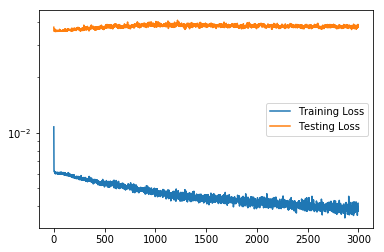

In [21]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Testing Loss')
plt.yscale("log")
pyplot.legend()
pyplot.show()

In [22]:
def rolling_seq_prediction(model,x_test,y_test):
    predictions = list()
    for i in x_test.index:
        # make one-step forecast
        X = x_test.loc[i].to_numpy().reshape(1,x_test.shape[1]) # reshape single line to have just 1 row
        y = y_test.loc[i]
        yhat = seq_model.predict(X).reshape(1) # reshape prediction to be just a 1D array
        # store forecast
        predictions.append(yhat[0])
    return predictions

In [23]:
yhat = rolling_seq_prediction(seq_model,x_test,y_test)
raw_seq_predictions = pd.DataFrame(yhat,columns = ['seq_prediction'], index = test_index)

In [24]:
# Invert scaling for prediction data
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
unscaled_seq_predictions = pd.concat([x_test, raw_seq_predictions], axis=1)
unscaled_seq_predictions = pd.concat([unscaled_seq_predictions, test_data.google_45d], axis=1)
unscaled_seq_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_seq_predictions), columns=unscaled_seq_predictions.columns, index=unscaled_seq_predictions.index)

# Invert scaling for actual data
unscaled_data = pd.concat([x_test, y_test], axis=1)
unscaled_data = pd.concat([unscaled_data, test_data.google_45d], axis=1)
unscaled_data = pd.DataFrame(scaler.inverse_transform(unscaled_data), columns=unscaled_data.columns, index=unscaled_data.index)
#unscaled_data = unscaled_data['google_45d_sta']

In [25]:
backup['unscaled_seq_predictions'] = unscaled_seq_predictions
backup['unscaled_data'] = unscaled_data

In [26]:
unscaled_seq_predictions.head()

,google_open_sta,google_high_sta,google_low_sta,google_close_sta,google_sta,google_volume,google_ra_04_sta,google_std_04,google_ra_09_sta,google_std_09,...,nasdaq_std_04,nasdaq_ra_09_sta,nasdaq_std_09,nasdaq_ra_18_sta,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,seq_prediction,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-01,-7.989990,-5.881958,-4.609985,-2.750000,-2.750000,1567200.0,-0.503337,1.515790,-2.072859,21.433011,...,38.687654,19.225725,109.753646,7.561348,85.881161,0.285090,0.083101,0.146205,3.985910,1161.219971
2018-08-02,22.099976,3.589966,5.419922,-6.140014,-6.140014,1531300.0,-1.786672,3.781604,3.132847,21.550840,...,73.619602,5.440011,106.402575,-0.333123,82.521365,0.271257,0.086055,0.164864,2.815065,1171.089966
2018-08-03,-23.719971,-0.119995,-10.270020,2.440063,2.440063,1089600.0,-0.992493,3.932133,5.712856,18.079647,...,69.648419,17.175781,81.003961,-0.449254,82.581619,0.214106,0.085981,0.165144,-3.209007,1186.869995
2018-08-06,4.619995,3.911987,-0.736938,-1.060059,-1.060059,1081700.0,-2.457489,0.749575,8.588562,3.444802,...,33.708070,-2.474772,90.494779,6.463542,87.849464,0.151643,0.065983,0.139857,12.214299,1166.089966
2018-08-07,-12.000000,-25.082031,-20.373047,-17.449951,-17.449951,1494000.0,-9.255005,12.338979,-2.897138,8.285092,...,16.956406,-19.488118,97.380328,-5.288330,91.512420,0.164522,0.060471,0.127694,0.055840,1173.369995


In [27]:
unscaled_data.head()

,google_open_sta,google_high_sta,google_low_sta,google_close_sta,google_sta,google_volume,google_ra_04_sta,google_std_04,google_ra_09_sta,google_std_09,...,nasdaq_std_04,nasdaq_ra_09_sta,nasdaq_std_09,nasdaq_ra_18_sta,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d_sta,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-01,-7.989990,-5.881958,-4.609985,-2.750000,-2.750000,1567200.0,-0.503337,1.515790,-2.072859,21.433011,...,38.687654,19.225725,109.753646,7.561348,85.881161,0.285090,0.083101,0.146205,-5.169922,1161.219971
2018-08-02,22.099976,3.589966,5.419922,-6.140014,-6.140014,1531300.0,-1.786672,3.781604,3.132847,21.550840,...,73.619602,5.440011,106.402575,-0.333123,82.521365,0.271257,0.086055,0.164864,-9.869995,1171.089966
2018-08-03,-23.719971,-0.119995,-10.270020,2.440063,2.440063,1089600.0,-0.992493,3.932133,5.712856,18.079647,...,69.648419,17.175781,81.003961,-0.449254,82.581619,0.214106,0.085981,0.165144,-15.780029,1186.869995
2018-08-06,4.619995,3.911987,-0.736938,-1.060059,-1.060059,1081700.0,-2.457489,0.749575,8.588562,3.444802,...,33.708070,-2.474772,90.494779,6.463542,87.849464,0.151643,0.065983,0.139857,20.780029,1166.089966
2018-08-07,-12.000000,-25.082031,-20.373047,-17.449951,-17.449951,1494000.0,-9.255005,12.338979,-2.897138,8.285092,...,16.956406,-19.488118,97.380328,-5.288330,91.512420,0.164522,0.060471,0.127694,-7.280029,1173.369995


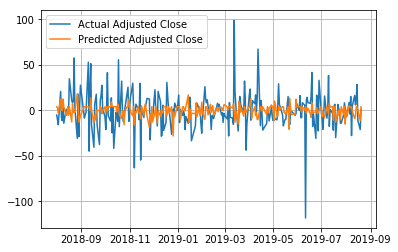

In [28]:
# Plot prediction vs actual
plt.plot(unscaled_data['google_45d_sta'], label='Actual Adjusted Close')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='Predicted Adjusted Close')
plt.grid()
plt.legend()
plt.show()

#### Reverse stationarity

In [29]:
def reverse_sta(df, sta_column, series):
    sum_prediction = []
    rolling_sum = 0
    for i in df.index:
        if rolling_sum == 0:
            rolling_sum = series.loc[i]
        rolling_sum += df[sta_column].loc[i]
        sum_prediction.append(rolling_sum)
    return sum_prediction

In [30]:
sum_prediction = reverse_sta(unscaled_seq_predictions, 'seq_prediction', df.google_45d)

In [31]:
df_predicted = pd.DataFrame(index=unscaled_seq_predictions.index)
df_predicted['seq_prediction'] = sum_prediction 
df_predicted = pd.concat([df_predicted,df.google_45d],axis=1)
df_predicted.dropna(inplace=True)
df_predicted.head()

,seq_prediction,google_45d
Date,,
2018-08-01,1165.205881,1161.219971
2018-08-02,1168.020946,1171.089966
2018-08-03,1164.811938,1186.869995
2018-08-06,1177.026237,1166.089966
2018-08-07,1177.082077,1173.369995


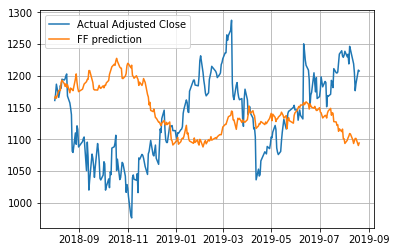

In [37]:
# Plot prediction vs actual
plt.plot(df_predicted.google_45d, label='Actual Adjusted Close')
plt.plot(df_predicted.seq_prediction, label='FF prediction')
plt.grid()
plt.legend()
plt.show()

In [39]:
seq_accuracy=np.sqrt(metrics.mean_squared_error(df_predicted.google_45d, df_predicted.seq_prediction))
seq_accuracy

92.60238579562633

### LSTM model

#### Split into train and test set
And here you have to be careful according to https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ :

"A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input. In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer. By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function."

But in order to can use "stateful = True" the data has to be a multiple of the batch size. Therefore I have to use modulo to get the test size correctly

In [40]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_sta_scaled, train_test_split, batch_size)

In [41]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
# Reshape data for (Sample, Timesteps, Features)
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_reshaped = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [42]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape = (x_train.shape[1], x_train.shape[2]), dropout = 0.2, return_sequences=True))#, stateful=True, batch_size=batch_size))
lstm_model.add(LSTM(units = 100, dropout = 0.2))#, return_sequences=False, stateful=True, batch_size=batch_size))
lstm_model.add(Dense(1))
adam = optimizers.Adam(lr=0.005)
lstm_model.compile(optimizer = adam, loss='mse')
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            56000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 136,501
Trainable params: 136,501
Non-trainable params: 0
_________________________________________________________________


In [43]:
start = time.time()
epochs = 100
lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test_reshaped, y_test),shuffle=False);
end = time.time()
time_lstm = end-start

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2370 samples, validate on 260 samples
Epoch 1/100
2370/2370 [==============================] - 5s 2ms/step - loss: 0.0065 - val_loss: 0.0360
Epoch 2/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0062 - val_loss: 0.0360
Epoch 3/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0062 - val_loss: 0.0379
Epoch 4/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0062 - val_loss: 0.0380
Epoch 5/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0062 - val_loss: 0.0381
Epoch 6/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0061 - val_loss: 0.0382
Epoch 7/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0061 - val_loss: 0.0403
Epoch 8/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0063 - val_loss: 0.0366
Epoch 9/100
2370/2370 [============

2370/2370 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0392
Epoch 77/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0056 - val_loss: 0.0437
Epoch 78/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0058 - val_loss: 0.0398
Epoch 79/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0392
Epoch 80/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0395
Epoch 81/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0057 - val_loss: 0.0423
Epoch 82/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0056 - val_loss: 0.0392
Epoch 83/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0406
Epoch 84/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0405
Epoch 85/100
2370/2370 [==============================] - 2s 1ms/step - loss:

In [44]:
lstm_model.evaluate(x_train, y_train, batch_size=batch_size)

2370/2370 [==============================] - 1s 240us/step


0.0053520484293643035

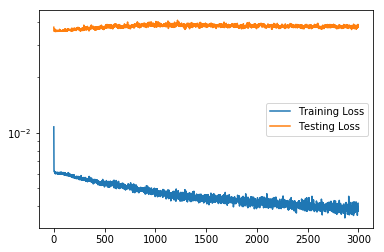

In [45]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Testing Loss')
plt.yscale("log")
pyplot.legend()

#### Get predictions

In [ ]:
def rolling_lstm_prediction(model,x_test,y_test):
    predictions = list()
    for i in range(len(x_test)):
        # make one-step forecast
        X = x_test[i,:] # select single line
        X = X.reshape(1, 1, len(X))  # reshape for LSTM
        y = y_test[i]
        yhat = lstm_model.predict(X, batch_size=1)[0] # reshape prediction to be just a 1D array
        # store forecast
        predictions.append(yhat[0])
    return predictions

In [ ]:
# Generate predictions
yhat = rolling_lstm_prediction(lstm_model,x_test,y_test);
raw_lstm_predictions = pd.DataFrame(yhat,columns = ['lstm_prediction'], index = test_index)

#### Convert data

In [ ]:
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
y_test = pd.DataFrame(y_test, columns = ['google_45d_sta'], index = test_index)

In [ ]:
# Invert scaling for prediction data
unscaled_lstm_predictions = pd.concat([x_test, raw_lstm_predictions], axis=1)
unscaled_lstm_predictions = pd.concat([unscaled_lstm_predictions, test_data.google_45d], axis=1)
unscaled_lstm_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_lstm_predictions), columns=unscaled_lstm_predictions.columns, index=unscaled_lstm_predictions.index)

# Invert scaling for actual data
test_data_unscaled = pd.concat([x_test, y_test], axis=1)
test_data_unscaled = pd.concat([test_data_unscaled, test_data.google_45d], axis=1)
test_data_unscaled = pd.DataFrame(scaler.inverse_transform(test_data_unscaled), columns=test_data_unscaled.columns, index=test_data_unscaled.index)

In [ ]:
backup['unscaled_lstm_predictions'] = unscaled_lstm_predictions
backup['test_data_unscaled'] = test_data_unscaled

In [ ]:
# Plot prediction vs actual
pyplot.plot(test_data_unscaled['google_45d_sta'], label='Stationary adjusted close')
pyplot.plot(unscaled_seq_predictions['seq_prediction'], label='FF Predicted')
pyplot.plot(unscaled_lstm_predictions['lstm_prediction'], label='LSTM Predicted')
plt.xlabel('Date')
plt.ylabel('USD')
pyplot.grid()
pyplot.legend()
pyplot.show()

In [ ]:
unscaled_lstm_predictions

#### Reverse stationary

In [ ]:
df_predicted['lstm_prediction'] = reverse_sta(unscaled_lstm_predictions, 'lstm_prediction', df.google_45d)
df_predicted.head()

In [ ]:
# plot google_45d and predicted
plt.plot(df_predicted.google_45d, label = 'Adjusted Close')
plt.plot(df_predicted.seq_prediction, label = 'FF prediction')
plt.plot(df_predicted.lstm_prediction, label = 'LSTM prediction')
plt.grid()
plt.legend()
plt.show()

In [ ]:
backup['df_predicted'] = df_predicted

In [ ]:
backup.close()

In [ ]:
lstm_accuracy=np.sqrt(metrics.mean_squared_error(df_predicted.google_45d, df_predicted.lstm_prediction))
print('Accuracy of feedforward model is {} \nAccuracy of LSTM model is {}'.format(round(seq_accuracy,2), round(lstm_accuracy)))

In [ ]:
print('Run time for feedforward model is {} seconds \nRun time for LSTM model is {} seconds'.format(time_seq,time_lstm))